# Overview
The goal of this script is to create engine evaluations for the moves of the player in question grouped by game stage.

For this, I will use the "stockfish" package. https://pypi.org/project/stockfish/

Furthermore, I will divide each game into the sections opening, middle game and endgame.

## Imports and Data load

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stockfish import Stockfish
import ast

In [ ]:
rapid_games = pd.read_csv("../data/rapid_games_Dec15(LAN).csv")
rapid_games.drop(columns='Unnamed: 0', axis=1, inplace=True) # - remove the index column

# convert date strings to date time:
rapid_games["createdAt"] = rapid_games["createdAt"].apply(pd.Timestamp)
rapid_games["lastMoveAt"] = rapid_games["lastMoveAt"].apply(pd.Timestamp)

# convert move sequence string to a list:
rapid_games["LAN"] = rapid_games["LAN"].str.split()

In [50]:
latest_date = rapid_games['createdAt'].max()
# only analyse the last 6 months of play
rapid_games = rapid_games[rapid_games['createdAt'] > pd.Timestamp(year=latest_date.year, month=latest_date.month - 6, day=latest_date.day, tz='UTC')]

In [ ]:
# loading the stockfish engine
from stockfish_extension import StockfishExt
sfe = StockfishExt("../stockfish/stockfish-windows-x86-64-avx2.exe")

# evaluate all the games of the dataframe
rapid_games["evaluation"] = rapid_games.apply(lambda x: sfe(x["LAN"]), axis=1)

### Depth of Search: Speed-Accuracy Tradeoff
- generally it is desirable to have a deeper stockfish evaluation, however, the time cost increases exponentially as depth increases.

Text(0.5, 1.0, 'Evaluation Time Cost by Depth (56-move game)')

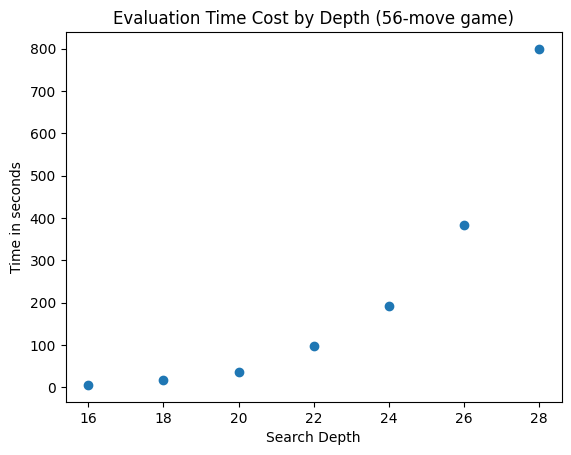

In [104]:
plt.scatter(depths, times)
plt.ylabel("Time in seconds")
plt.xlabel("Search Depth")
plt.title(f"Evaluation Time Cost by Depth ({len(move_list)}-move game)")

In [139]:
time_cost = pd.DataFrame(depths, columns=["depth"])
time_cost["computational cost in hours"] = list(map(lambda x: x* 5539/3600, times))
time_cost["computational cost in hours"] = time_cost["computational cost in hours"].astype(int)
time_cost

,depth,computational cost in hours
0,16,8
1,18,24
2,20,54
3,22,149
4,24,296
5,26,588
6,28,1229


### Centipawn changes and Blunder metric

In [6]:
def get_cp_losses(evals, white):
    eval_changes = [] # first move eval change as 0
    if white:
        eval_changes.append(0)
        for i in range(1,len(evals)):
            eval_changes.append(evals[i-1] - evals[i])
        return eval_changes[::2] # for white
    else:
        for i in range(1,len(evals)):
            eval_changes.append(evals[i] - evals[i-1])
        return eval_changes[::2] # for Black


In [7]:
rapid_games["cp_losses"] = [get_cp_losses(eval, username==white) for eval, username, white, in zip(rapid_games["evaluation"], rapid_games["username"], rapid_games["white"])]

### Averaged Centipawn loss

In [ ]:
rapid_games["averaged_cp_loss"] = rapid_games["cp_losses"].apply(np.mean)

### Number of Blunders

I will use a simple definition for a blunder:
If a move loses 200 centipawns or more, it counts as a blunder.

In [8]:
rapid_games["blunders"] = rapid_games["cp_losses"].apply(lambda x: sum(i>200 for i in x))

### Thinking Times

In [11]:
rapid_games["clocks"] = rapid_games["clocks"].apply(ast.literal_eval)
rapid_games["clock"] = rapid_games["clock"].apply(ast.literal_eval)
rapid_games["increment"] = rapid_games["clock"].apply(lambda x: x.get("increment"))

In [13]:
def get_move_times(clocks: list, white: bool, increment=0):
    if white:
        clocks = clocks[::2]
    else:
        clocks = clocks[1::2]

    return [((clocks[i-1] - clocks[i])/100) + increment for i in range(1, len(clocks))]

In [14]:
rapid_games["moveTimes"] = rapid_games.apply(lambda x: get_move_times(x["clocks"], x["username"]==x["white"], x["increment"]), axis=1)

### Save data

In [19]:
rapid_games.to_csv("../data/rapid_games_Dec15final.csv", index=False)